# KOSPI와 외부데이터 간의 상관관계 분석하여 KOSPI전망을 다양한 방법으로 예측
- 코스피에는 우리가 전부 알수없는 다양한 잠재적 변수가 적용되므로 다양한 데이터를 가지고 예측해본다.

---
### 사용 라이브러리
---

In [1]:
# 기본 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from IPython.display import clear_output

# 경고 뜨지 않게..
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'Apple Gothic' # 맥북
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams['axes.unicode_minus'] = False

# 랜덤 모듈
import random 

# 딥러닝 라이브러리
import tensorflow as tf
# 신경망 모델을 관리하는 객체
from tensorflow.keras.models import Sequential
# CNN : 커널을 통해 합성곱을 구하는 것, 특징을 두드러지게 한다.
from tensorflow.keras.layers import Conv1D
# 선형 회귀 레이어
from tensorflow.keras.layers import Dense
# 활성화 함수를 정의하는 객체
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
# LSTM
from tensorflow.keras.layers import LSTM

from tensorflow.keras.layers import Input, TimeDistributed, RepeatVector, Bidirectional

from tensorflow.keras.optimizers import Adam

# 저장된 학습모델 복원
from tensorflow.keras.models import load_model
# 모델 자동 저장
from tensorflow.keras.callbacks import ModelCheckpoint
# 성능이 더이상 좋아지지 않을 경우 중단
from tensorflow.keras.callbacks import EarlyStopping

# 표준화
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# 전체데이터를 학습용과 검즘용으로 나누기
from sklearn.model_selection import train_test_split

---
### 공공 데이터 포털, KOSIS 국가 통계포털, E-나라지표, 한국은행경제통계시스템, Yahoo Finance에서 자료 수집
- 일별 데이터가 없는 데이터가 많아 월별로 평균을 내어 데이터를 병합.
- 전처리 과정이 너무 길어 생략후 csv파일을 불러와 분석 및 시각화 진행
- KOSPI를 포함한 주가 관련 데이터는 종가 기준으로 사용
---

In [2]:
# 미리 수집하여 전처리한 데이터를 불러온다.
df1 = pd.read_csv('./data/코스피상관관계 월별.csv')
# 데이터 결측치 및 데이터 타입 확인
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    242 non-null    int64  
 1   일자            242 non-null    object 
 2   코스피           242 non-null    float64
 3   코스피200        242 non-null    float64
 4   S&P500        242 non-null    float64
 5   금값            242 non-null    float64
 6   나스닥           242 non-null    float64
 7   넷플릭스          242 non-null    float64
 8   물가지수          242 non-null    float64
 9   상해종합          242 non-null    float64
 10  주택매매가격지수      242 non-null    float64
 11  통화량(십억원)      242 non-null    float64
 12  무담보콜금리 전체     242 non-null    float64
 13  담보콜금리전체       242 non-null    float64
 14  CD(91일)       242 non-null    float64
 15  국고채(3년)       242 non-null    float64
 16  회사채(3년, AA-)  242 non-null    float64
 17  니케이           242 non-null    float64
 18  실업률           242 non-null    

In [3]:
# 일자컬럼의 데이터 타입을 변겅한다.
df1['일자'] = pd.to_datetime(df1['일자'], format = '%Y-%m')
df1.head()

,Unnamed: 0,일자,코스피,코스피200,S&P500,금값,나스닥,넷플릭스,물가지수,상해종합,...,국고채(3년),"회사채(3년, AA-)",니케이,실업률,미국달러환율,중국위안환율,일본100엔환율,유로,WTI유가전처리,필라델피아반도체
0,0,2002-05-01,844.778182,105.976818,1067.14,326.55,1660.310913,1.135834,78.37,1577.194661,...,6.30,7.07,11709.623419,3.1,1266.06,0.0,1001.56,1160.82,25.31,476.3
1,1,2002-06-01,785.747222,98.738333,989.82,314.45,1505.488489,1.038071,77.87,1562.779449,...,5.93,6.76,10965.875977,2.9,1223.47,0.0,993.12,1169.42,26.86,387.6
2,2,2002-07-01,754.257619,94.774762,911.62,303.55,1346.085455,1.110000,77.65,1695.699330,...,5.70,6.59,10352.265243,3.0,1185.12,0.0,1003.88,1175.59,27.02,330.9
3,3,2002-08-01,712.824286,89.500476,916.07,312.75,1327.360463,0.870974,77.75,1660.573054,...,5.37,6.23,9751.204590,3.2,1196.37,0.0,1004.44,1170.00,28.98,300.2
4,4,2002-09-01,705.708000,88.293500,815.28,323.55,1251.069006,0.828071,77.91,1619.580707,...,5.37,6.06,9354.008429,2.7,1208.50,0.0,1001.56,1184.33,30.45,238.2


In [4]:
# 히트맵을 그리기 위해 일자컬럼을 index로 옮기고 필요없는 컬럼 제거
df1.index = df1['일자']
df2 = df1.drop(['일자','Unnamed: 0'], axis=1)
df2.head()

,코스피,코스피200,S&P500,금값,나스닥,넷플릭스,물가지수,상해종합,주택매매가격지수,통화량(십억원),...,국고채(3년),"회사채(3년, AA-)",니케이,실업률,미국달러환율,중국위안환율,일본100엔환율,유로,WTI유가전처리,필라델피아반도체
일자,,,,,,,,,,,,,,,,,,,,,
2002-05-01,844.778182,105.976818,1067.14,326.55,1660.310913,1.135834,78.37,1577.194661,46.910,812805.7,...,6.30,7.07,11709.623419,3.1,1266.06,0.0,1001.56,1160.82,25.31,476.3
2002-06-01,785.747222,98.738333,989.82,314.45,1505.488489,1.038071,77.87,1562.779449,47.118,822108.1,...,5.93,6.76,10965.875977,2.9,1223.47,0.0,993.12,1169.42,26.86,387.6
2002-07-01,754.257619,94.774762,911.62,303.55,1346.085455,1.110000,77.65,1695.699330,47.574,827976.6,...,5.70,6.59,10352.265243,3.0,1185.12,0.0,1003.88,1175.59,27.02,330.9
2002-08-01,712.824286,89.500476,916.07,312.75,1327.360463,0.870974,77.75,1660.573054,48.402,831521.4,...,5.37,6.23,9751.204590,3.2,1196.37,0.0,1004.44,1170.00,28.98,300.2
2002-09-01,705.708000,88.293500,815.28,323.55,1251.069006,0.828071,77.91,1619.580707,49.563,842512.0,...,5.37,6.06,9354.008429,2.7,1208.50,0.0,1001.56,1184.33,30.45,238.2


---
### 코스피를 예측해볼 데이터를 상관관계를 통해 선별한다.
---

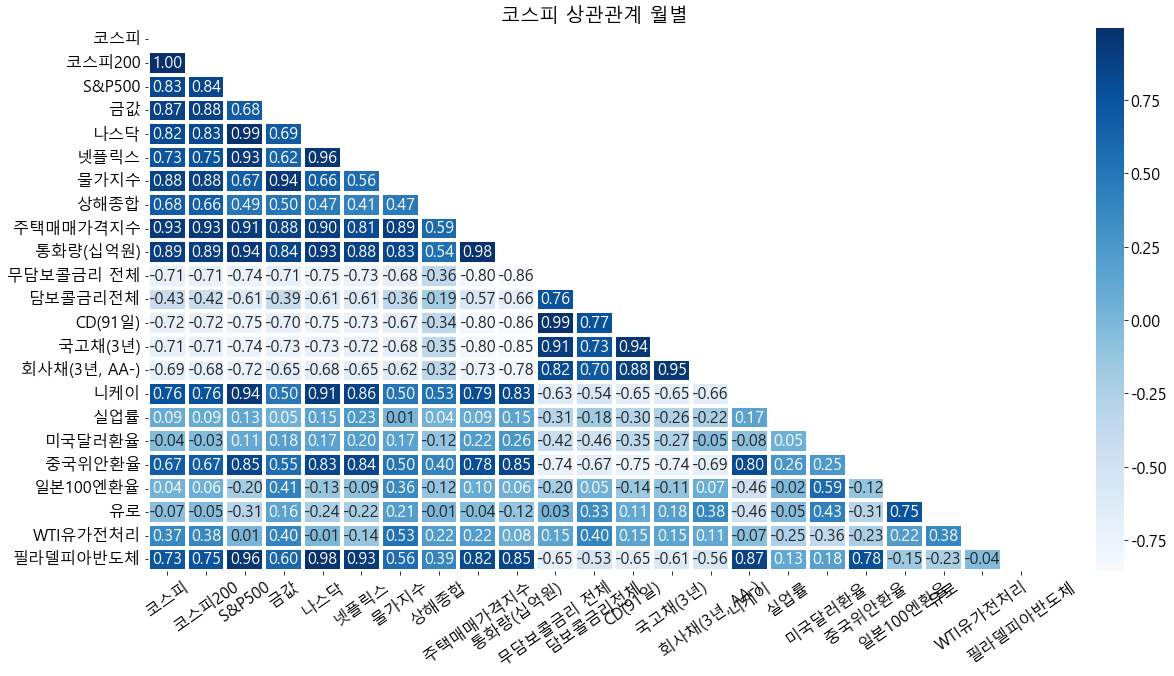

In [5]:
# 히트맵을 그려 코스피와의 상관관계를 확인한다.
df3 = df2.corr()
mask = np.zeros_like(df3, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df3, mask = mask, annot=True, linewidths=4, fmt='.2f', cmap='Blues')
plt.xticks(rotation=35)
plt.title('코스피 상관관계 월별')
plt.show()

In [6]:
# 그래프로 시각화해 패턴을 확인하기 위해 데이터를 표준화한다.
scaler1 = StandardScaler()
X = scaler1.fit_transform(df2)
X

array([[-1.56632135, -1.57142562, -0.86481126, ..., -1.49266141,
        -1.67938176, -0.47915588],
       [-1.66387394, -1.66121781, -0.94566399, ..., -1.43446888,
        -1.61591814, -0.58605773],
       [-1.71591261, -1.71038526, -1.02743694, ..., -1.39271912,
        -1.60936705, -0.65439296],
       ...,
       [ 1.49990337,  1.53125168,  2.34000838, ..., -0.32028486,
         1.57077454,  2.46564655],
       [ 1.38116016,  1.42483003,  2.34023843, ..., -0.26378397,
         1.97939837,  2.68137858],
       [ 1.1485487 ,  1.15629403,  1.97762458, ..., -0.21959824,
         1.63341928,  2.02767438]])

In [7]:
# 표준화한 데이터를 seaborn로 그래프를 그리기 위해 데이터프레임으로 변경한다.
df4 = pd.DataFrame(X)
df4.index = df2.index
df4.columns = df2.columns
df4.reset_index(inplace=True)
df4.head()

,일자,코스피,코스피200,S&P500,금값,나스닥,넷플릭스,물가지수,상해종합,주택매매가격지수,...,국고채(3년),"회사채(3년, AA-)",니케이,실업률,미국달러환율,중국위안환율,일본100엔환율,유로,WTI유가전처리,필라델피아반도체
0,2002-05-01,-1.566321,-1.571426,-0.864811,-1.682886,-0.846880,-0.686256,-2.000308,-1.183638,-1.793874,...,2.170597,1.963289,-0.683153,-0.864087,1.538047,-0.6887,-0.416544,-1.492661,-1.679382,-0.479156
1,2002-06-01,-1.663874,-1.661218,-0.945664,-1.708515,-0.890550,-0.686839,-2.052633,-1.199823,-1.777046,...,1.912621,1.771307,-0.810025,-1.264679,1.086914,-0.6887,-0.463603,-1.434469,-1.615918,-0.586058
2,2002-07-01,-1.715913,-1.710385,-1.027437,-1.731602,-0.935513,-0.686410,-2.075656,-1.050583,-1.740155,...,1.752257,1.666026,-0.914697,-1.064383,0.680694,-0.6887,-0.403608,-1.392719,-1.609367,-0.654393
3,2002-08-01,-1.784384,-1.775812,-1.022784,-1.712115,-0.940795,-0.687834,-2.065191,-1.090022,-1.673169,...,1.522170,1.443079,-1.017228,-0.663791,0.799859,-0.6887,-0.400486,-1.430544,-1.529116,-0.691393
4,2002-09-01,-1.796144,-1.790784,-1.128179,-1.689240,-0.962314,-0.688090,-2.048447,-1.136047,-1.579244,...,1.522170,1.337798,-1.084983,-1.665271,0.928345,-0.6887,-0.416544,-1.333579,-1.468928,-0.766116


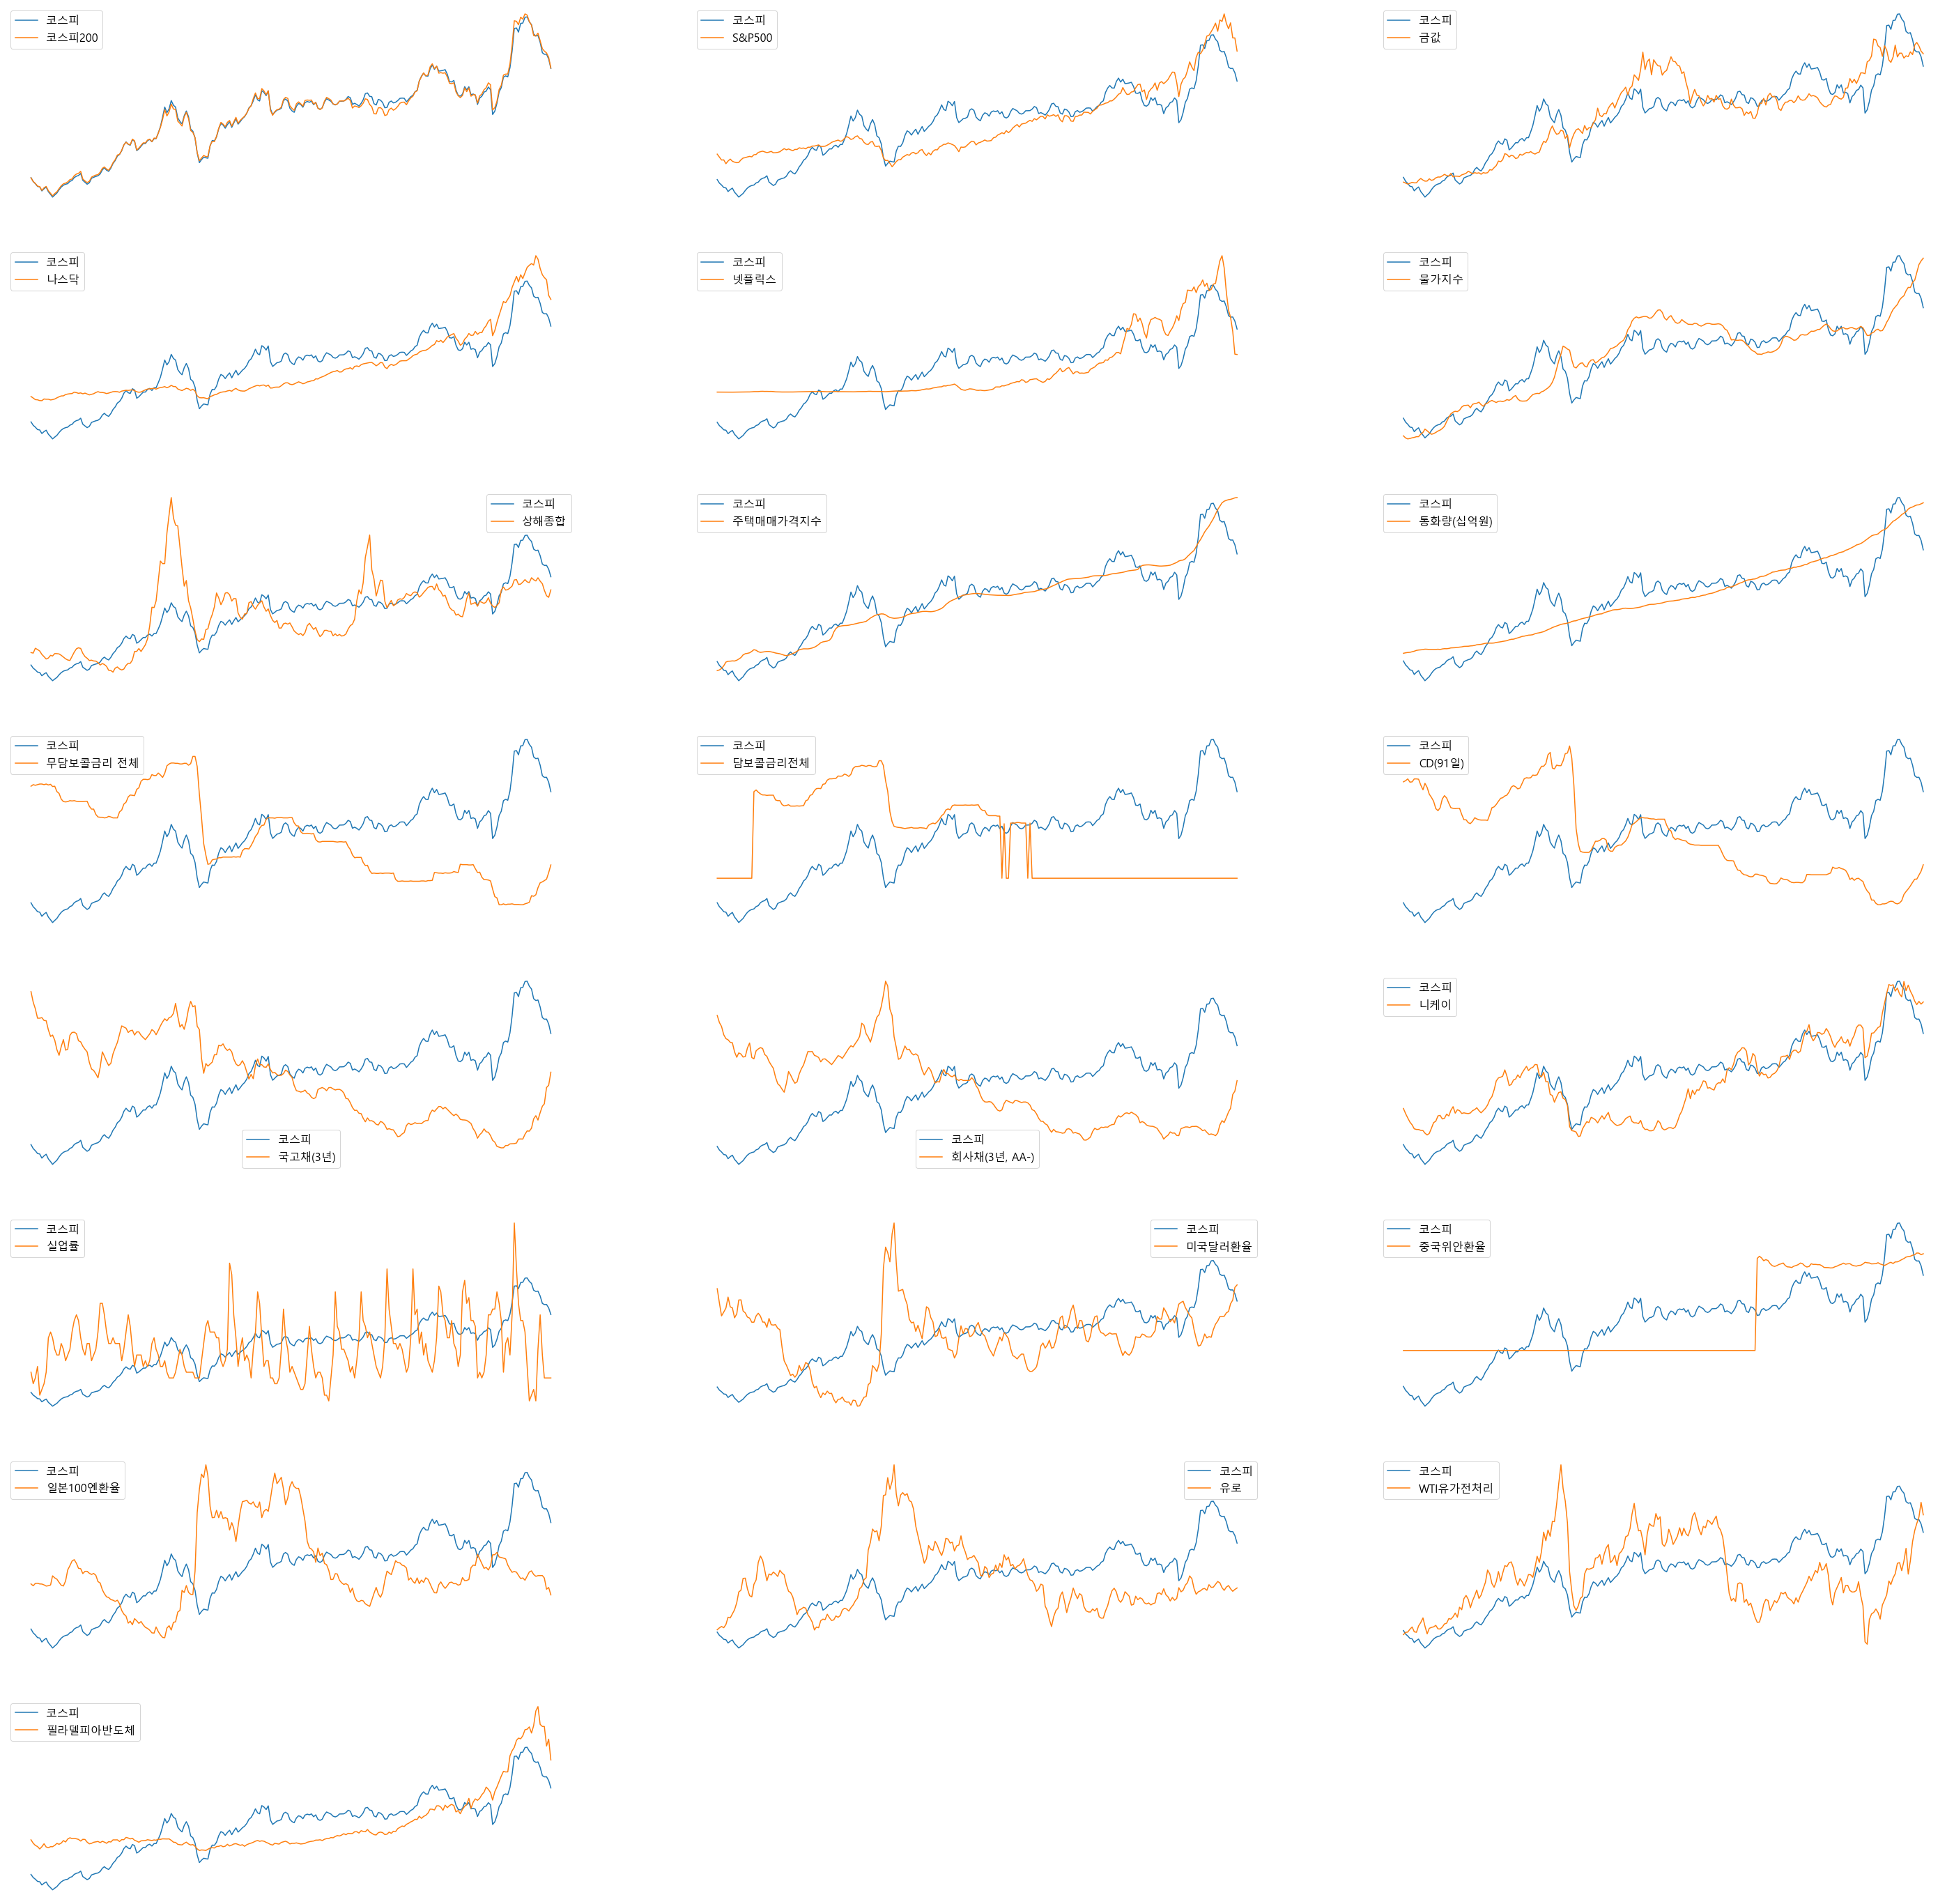

In [8]:
# 그래프를 코스피와 1대1로 비교하여 패턴을 파악한다.
a = df2.columns[1:]
plt.figure(figsize=(50,50))
for idx, col in enumerate(a) :
    plt.subplot(8,3,1+int(idx))
    sns.lineplot(data=df4, x='일자', y='코스피',label='코스피')
    sns.lineplot(data=df4, x='일자', y=col,label=col)
    plt.axis('off')
plt.show()

In [9]:
# 히트맵과 그래프를 고려하여 학습시킬 컬럼을 선별한 후 리스트로 저장한다.(히트맵은 상관계수 0.7 이상)
col_list = ['필라델피아반도체','S&P500','WTI유가전처리', '금값', '나스닥', '물가지수','상해종합','주택매매가격지수']

---
### 코스피 종가로만 코스피 종가를 예측해본다.
---
- LSTM : 데이터의 발생 시간 순서를 이용하여 신경망 시스템 내부적으로 입력변수 정보를 기억함으로써 시계열 자료의 시간적 앞뒤 순서를 고려할 수 있다.
- LSTM_AE : 오토인코더의 인코더는 입력받은 시퀀스로부터 특징을 추출하고 이를 저차원의고정 길이 벡터로 변환하여 패턴을 학습한다.
- BI-LSTM : 순방향과 역방향의 신경망들을사용하여 학습을 시키기 때문에 최근 패턴뿐만이 아니라 과거의 패턴도 고려하여 성능을 향상시킨다
- ARIMA : 거의 모든 형태의 시계열 자료에 적용할 수 있으며, 
계절적 변동과 다른 주기적인 변동이 동시에 존재하는 시계열 자료를
예측할 때 유용하게 사용할 수 있다.
과거 시점보다는 최근 시점에 가까운 관측값에 더 많은 비중을 주기 때문에
단기 예측에 보다 적합하다고 할수 있다.
- Prophet : 2018년 Facebook에서 제안한 시계열 예측모형으로, 시계열의 시간
종속적인 특성을 고려하는 기존의 시계열 모형들과는 달리 곡선 적합으로 모형을 적
합한다. 이를 통해 Prophet은 많은 장점을 갖는다. 예를 들면, 결측치와 이상점에 로
버스트하고 강한 계절성을 가지는 자료에도 잘 작동한다

---
---

In [10]:
# 선별한 컬럼만 새로운 데이터프레임에 저장한다.
df5 = df2[['코스피']]
df5[col_list] = df2[col_list]
df5.reset_index(inplace=True)
df5.head()

,일자,코스피,필라델피아반도체,S&P500,WTI유가전처리,금값,나스닥,물가지수,상해종합,주택매매가격지수
0,2002-05-01,844.778182,476.3,1067.14,25.31,326.55,1660.310913,78.37,1577.194661,46.910
1,2002-06-01,785.747222,387.6,989.82,26.86,314.45,1505.488489,77.87,1562.779449,47.118
2,2002-07-01,754.257619,330.9,911.62,27.02,303.55,1346.085455,77.65,1695.699330,47.574
3,2002-08-01,712.824286,300.2,916.07,28.98,312.75,1327.360463,77.75,1660.573054,48.402
4,2002-09-01,705.708000,238.2,815.28,30.45,323.55,1251.069006,77.91,1619.580707,49.563


In [11]:
# Prophet에서 지원하는 형식으로 변환 날짜와 학습시킬 데이터는 columns이름을 각각 ds와 y로 바꾼다.
train_df = df5.rename(columns={'일자' : 'ds', '코스피' : 'y'})
train_df.head()

,ds,y,필라델피아반도체,S&P500,WTI유가전처리,금값,나스닥,물가지수,상해종합,주택매매가격지수
0,2002-05-01,844.778182,476.3,1067.14,25.31,326.55,1660.310913,78.37,1577.194661,46.910
1,2002-06-01,785.747222,387.6,989.82,26.86,314.45,1505.488489,77.87,1562.779449,47.118
2,2002-07-01,754.257619,330.9,911.62,27.02,303.55,1346.085455,77.65,1695.699330,47.574
3,2002-08-01,712.824286,300.2,916.07,28.98,312.75,1327.360463,77.75,1660.573054,48.402
4,2002-09-01,705.708000,238.2,815.28,30.45,323.55,1251.069006,77.91,1619.580707,49.563


In [12]:
train_df[['ds','y']]

,ds,y
0,2002-05-01,844.778182
1,2002-06-01,785.747222
2,2002-07-01,754.257619
3,2002-08-01,712.824286
4,2002-09-01,705.708000
...,...,...
237,2022-02-01,2722.530000
238,2022-03-01,2699.054286
239,2022-04-01,2700.210000
240,2022-05-01,2628.356190


In [13]:
# 2015년 10월 이후 80개월을 예측하기 위해 데이터를 나눈다.
test_df = train_df.iloc[-80:]
train_df = train_df.iloc[:-80]

In [14]:
# Prophet에서 학습
from prophet import Prophet
m = Prophet()
m.fit(train_df)

09:50:52 - cmdstanpy - INFO - Chain [1] start processing
09:50:52 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
# periods는 예측일수, freq는 D는 일별, M은 달별로 분석
future = m.make_future_dataframe(periods=80, freq='M')
future.head()

,ds
0,2002-05-01
1,2002-06-01
2,2002-07-01
3,2002-08-01
4,2002-09-01


In [16]:
# 예측값 추출
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
237,2022-01-31,2515.121428,2303.392704,2777.829100,2416.517697,2618.240899,27.249823,27.249823,27.249823,27.249823,27.249823,27.249823,0.0,0.0,0.0,2542.371251
238,2022-02-28,2519.971810,2136.472659,2592.973750,2419.492611,2625.824370,-151.409662,-151.409662,-151.409662,-151.409662,-151.409662,-151.409662,0.0,0.0,0.0,2368.562148
239,2022-03-31,2525.341876,2278.819582,2761.177342,2423.422697,2634.768268,-15.739557,-15.739557,-15.739557,-15.739557,-15.739557,-15.739557,0.0,0.0,0.0,2509.602319
240,2022-04-30,2530.538714,2331.573220,2811.210313,2425.749995,2641.247304,45.674343,45.674343,45.674343,45.674343,45.674343,45.674343,0.0,0.0,0.0,2576.213057
241,2022-05-31,2535.908780,2324.637651,2824.294756,2429.802596,2648.917434,38.239172,38.239172,38.239172,38.239172,38.239172,38.239172,0.0,0.0,0.0,2574.147952


In [17]:
# 기존에 사용하는 날짜와 일(d)이 맞지 않아 기존 데이터와 동일하게 변환
forecast['ds'] = forecast['ds'].dt.strftime('%Y-%m-%d')
forecast['ds'] = forecast['ds'].str[:7]
forecast['ds'] = pd.to_datetime(forecast['ds'], format = '%Y-%m')

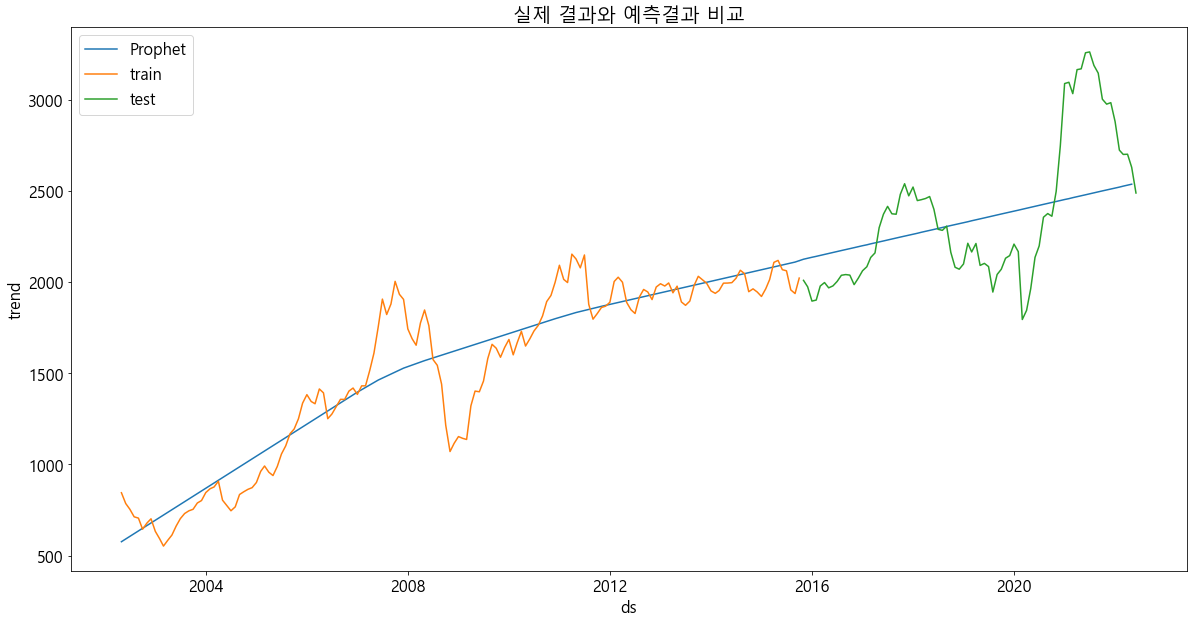

In [19]:
# 실제 결과와 에측결과 비교
plt.title('실제 결과와 예측결과 비교')
sns.lineplot(data=forecast, x='ds', y='trend', label='Prophet')
sns.lineplot(data=train_df, x='ds', y='y', label='train')
sns.lineplot(data=test_df, x='ds', y='y', label='test')
plt.show()

In [ ]:
# 아리마 사용하여 코스피 예측
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.arima_model as smt
import statsmodels
from itertools import product

In [ ]:
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(product(p,d,q))  #조합 만들기

#최적의 파라미터 찾기
# AIC score 는 낮을수록 좋음. (2,1,2)
aic =[]
for i in pdq:
  model_fit = sm.tsa.arima.ARIMA(train_df['y'], order=(i)).fit()
  # model_fit = model.fit()
  print(f'ARIMA:{i} >> AIC : {round(model_fit.aic,2)}')
  aic.append(round(model_fit.aic,2))

ARIMA:(0, 1, 0) >> AIC : 1820.25
ARIMA:(0, 1, 1) >> AIC : 1807.04
ARIMA:(0, 1, 2) >> AIC : 1807.34
ARIMA:(1, 1, 0) >> AIC : 1810.71
ARIMA:(1, 1, 1) >> AIC : 1806.53
ARIMA:(1, 1, 2) >> AIC : 1808.34
ARIMA:(2, 1, 0) >> AIC : 1810.5
ARIMA:(2, 1, 1) >> AIC : 1808.3
ARIMA:(2, 1, 2) >> AIC : 1810.02


In [ ]:
# 찾은 파라미터 입력후 학습
model_fit = sm.tsa.arima.ARIMA(train_df['y'], order=(2, 1, 2), trend='t').fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  162
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -899.449
Date:                Tue, 27 Sep 2022   AIC                           1810.898
Time:                        23:44:43   BIC                           1829.386
Sample:                             0   HQIC                          1818.405
                                - 162                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             7.2763      7.510      0.969      0.333      -7.444      21.996
ar.L1          0.0293      1.650      0.018      0.986      -3.205       3.264
ar.L2          0.2306      0.603      0.383      0.7

In [ ]:
# steps는 예측일수
forecast_data = model_fit.forecast(steps=80)
forecast_data

162    2040.513821
163    2045.144557
164    2055.078468
165    2061.822649
166    2069.696231
          ...     
237    2586.360359
238    2593.636699
239    2600.913040
240    2608.189381
241    2615.465721
Name: predicted_mean, Length: 80, dtype: float64

In [ ]:
# 예측한 값을 그래프로 그리기 위해 데이터 프레임으로  변경후 날짜 입력
b = pd.DataFrame(forecast_data)
b['ds']=forecast['ds']

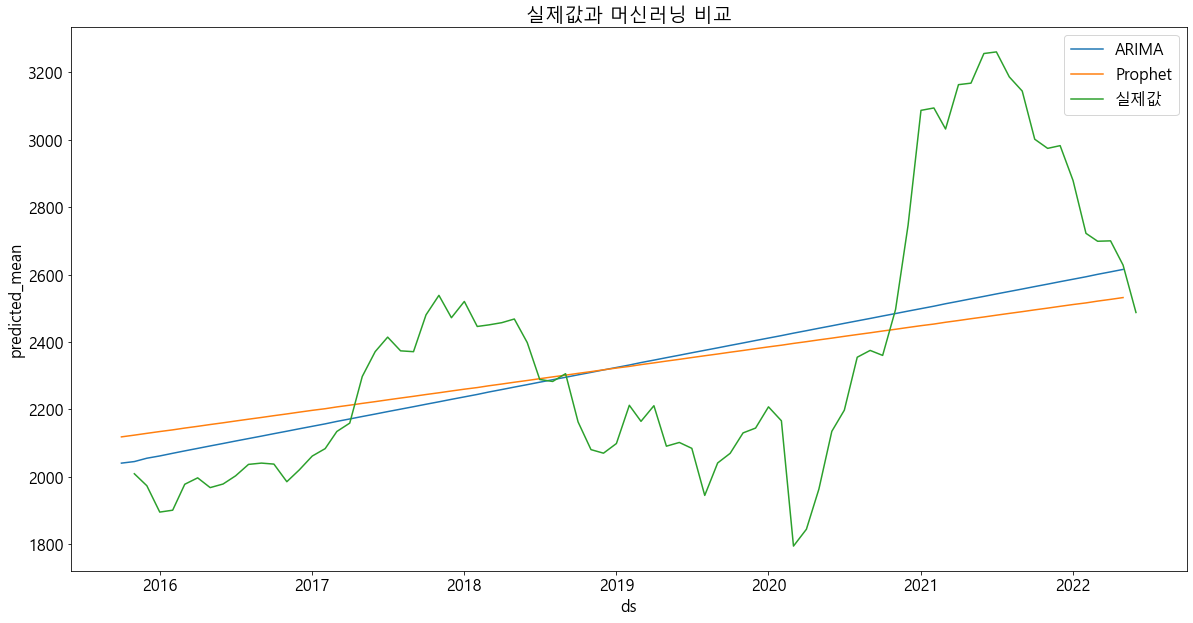

In [ ]:
# 예측결과 비교
plt.title('실제값과 머신러닝 비교')
sns.lineplot(data=b, x='ds',y='predicted_mean', label='ARIMA')
sns.lineplot(data=forecast.iloc[-80:], x='ds', y='trend', label='Prophet')
sns.lineplot(data=test_df, x='ds', y='y', label='실제값')
plt.show()

---
### 딥러닝을 위한 전처리
---

In [ ]:
# 딥러닝 학습을 위해 입력과 결과로 나눈다
X = df2[['코스피']]
y = df2['코스피']

In [ ]:
# 딥러닝 학습을 위해 표준화한다.
scaler2 = StandardScaler()
X = scaler2.fit_transform(X)
scaler3 = MinMaxScaler()
y = scaler3.fit_transform(y.values.reshape(-1, 1))

In [ ]:
# 회귀
# 출력 결과를 하나만 뽑아서 Series로 나왔다면...
# 1로 설정한다.
if type(y) is pd.core.series.Series :
    out_nodes = 1
else :
    out_nodes = y.shape[1]

In [ ]:
# 입력노드의 개수
input_size = X.shape[1]
input_size

1

In [ ]:
# 시퀀스 데이터셋 구성
# 시퀀스 데이터 : 순서를 가지고 있는 데이터를 의미한다.
def windowed_dataset(series, window_size, batch_size, shuffle) :
    # 데이터의 차원을 1차원으로 조정한다.
    series = tf.expand_dims(series, axis=-1)
    # 데이터셋 객체를 생성한다.
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w : w.batch(window_size + 1))
    if shuffle == True :
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w : (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
# 머신러닝과 동일하게 80개월을 에측하기위해 데이터를 분리한다.(20개월치로 다음달을 예측하기에 100개월치를 test데이터로 사용)
X_train = X[:-100]
X_test = X[-100:]
y_train = y[:-100]
y_test = y[-100:]

In [ ]:
# 결과를 확인하기 위한 앞선 데이터의 수
WINDOW_SIZE = 20
# 데이터 배치 사이즈
BATCH_SIZE = 32
# optimizer
optimizer = 'adam'
# Loss
loss = 'mse'

In [ ]:
# train_data는 학습용 데이터셋, test_data는 검증용 데이터 셋
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

### LSTM

In [ ]:
# 신경망 설계
model_LSTM = Sequential()
# CNN
model_LSTM.add(Conv1D(32, kernel_size=3,
                padding='causal',
                input_shape=[WINDOW_SIZE, 1]))
model_LSTM.add(Activation('relu'))

# LSTM
model_LSTM.add(LSTM(16))
model_LSTM.add(Activation('tanh'))
model_LSTM.add(Dropout(0.5))
# 선형
model_LSTM.add(Dense(16))
model_LSTM.add(Activation('relu'))


# 출력층
model_LSTM.add(Dense(out_nodes))

# 모델 컴파일
model_LSTM.compile(loss=loss, optimizer=optimizer)
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 32)            128       
                                                                 
 activation (Activation)     (None, 20, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 activation_1 (Activation)   (None, 16)                0         
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 activation_2 (Activation)   (None, 16)                0

### BI_LSTM

In [ ]:
# 신경망 설계
model_BI_LSTM = Sequential()
# CNN
model_BI_LSTM.add(Conv1D(32, kernel_size=3,
                padding='causal',
                input_shape=[WINDOW_SIZE, 1]))
model_BI_LSTM.add(Activation('relu'))

# 양방향 LSTM
model_BI_LSTM.add(Bidirectional(LSTM(16, return_sequences=True)))
model_BI_LSTM.add(Bidirectional(LSTM(16)))
model_BI_LSTM.add(Dropout(0.5))

# 출력층
model_BI_LSTM.add(Dense(out_nodes))

# 모델 컴파일
model_BI_LSTM.compile(loss=loss, optimizer=optimizer)
model_BI_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 20, 32)            128       
                                                                 
 activation_3 (Activation)   (None, 20, 32)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 32)           6272      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

### LSTM_AE

In [ ]:
# 신경망 설계
model_LSTM_AE = Sequential()
# CNN
model_LSTM_AE.add(Conv1D(32, kernel_size=3,
           padding='causal',
           input_shape=[WINDOW_SIZE, 1]))
model_LSTM_AE.add(Activation('relu'))

model_LSTM_AE.add(LSTM(32))
model_LSTM_AE.add(Activation('relu'))
# model_LSTM_AE.add(Dropout(0.5))
model_LSTM_AE.add(RepeatVector(out_nodes))
model_LSTM_AE.add(LSTM(32, return_sequences=True))
model_LSTM_AE.add(Activation('relu'))
# model_LSTM_AE.add(Dropout(0.5))
model_LSTM_AE.add(TimeDistributed(Dense(1)))

model_LSTM_AE.compile(loss=loss, optimizer=optimizer)
model_LSTM_AE.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 20, 32)            128       
                                                                 
 activation_4 (Activation)   (None, 20, 32)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 activation_5 (Activation)   (None, 32)                0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 32)            0         
 )                                                               
                                                                 
 lstm_4 (LSTM)               (None, 1, 32)             8320      
                                                      

In [ ]:
# 학습모델을 저장할 경로
path = './model'
# 만약 폴더가 있다면 삭제한다.
if os.path.isdir(path) :
    shutil.rmtree(path)
# 폴더를 생성한다.
os.makedirs(os.path.join(path))

In [ ]:
model_dic = {'model_LSTM' : model_LSTM,
              'model_BI_LSTM' : model_BI_LSTM,
              'model_LSTM_AE' : model_LSTM_AE}
history_dic = {'history' : []}
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):    
    clear_output(wait=True)
for models in model_dic:
    path1 = path + f'/{models}.h5'
    # 저장콜백
    callbacks = [ModelCheckpoint(filepath=path1, monitor='val_loss', save_best_only=True),
                 EarlyStopping(monitor='val_loss', patience=50), 
                 TensorBoard(log_dir=path +'./logs', histogram_freq=1),
                 DisplayCallback()
                ]
    history = model_dic[models].fit(train_data,
                       validation_data=(test_data),
                       epochs=10000,
                       callbacks=callbacks)
    history_dic['history'].append(history)
    print(f'{models} 학습완료')

4/4 [==============================] - 0s 46ms/step - loss: 9.7705e-04 - val_loss: 0.0130
model_LSTM_AE 학습완료


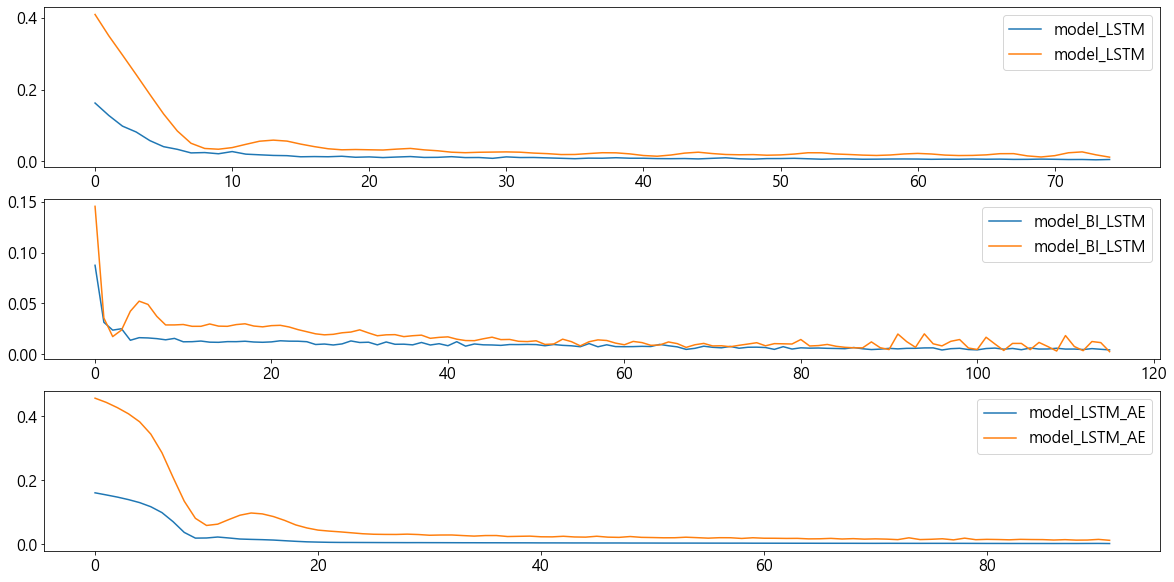

In [ ]:
# 손실률 그래프로 시각화
for idx, his in enumerate(history_dic['history']):
    # 리스트를 추출한다.
    loss_list = his.history['loss']
    val_loss_list = his.history['val_loss']
    # 손실률
    plt.subplot(311+idx)
    plt.plot(loss_list[:-50], label=list(model_dic.keys())[idx])
    plt.plot(val_loss_list[:-50], label=list(model_dic.keys())[idx])
    plt.legend()
plt.show()

In [ ]:
# 모델을 가져온다.
model_LSTM = load_model('./model/model_LSTM.h5')
model_BI_LSTM = load_model('./model/model_BI_LSTM.h5')
model_LSTM_AE = load_model('./model/model_LSTM_AE.h5')

In [ ]:
# 검증데이터를 통해 예측 결과를 가져온다.
pred1 = model_LSTM.predict(test_data)
pred1 = pred1.reshape(-1)
pred2 = model_BI_LSTM.predict(test_data)
pred2 = pred2.reshape(-1)
pred3 = model_LSTM_AE.predict(test_data)
pred3 = pred3.reshape(-1)

3/3 [==============================] - 1s 11ms/step


In [ ]:
# 원래 결과를 1차원으로 변환한다.
y_test2 = y_test.reshape(-1)
# 20일치를 가지고 21일째를 예측하기 떄문에
# 앞선 20일은 예측하지 않는다.
y_test2 = y_test2[20:]

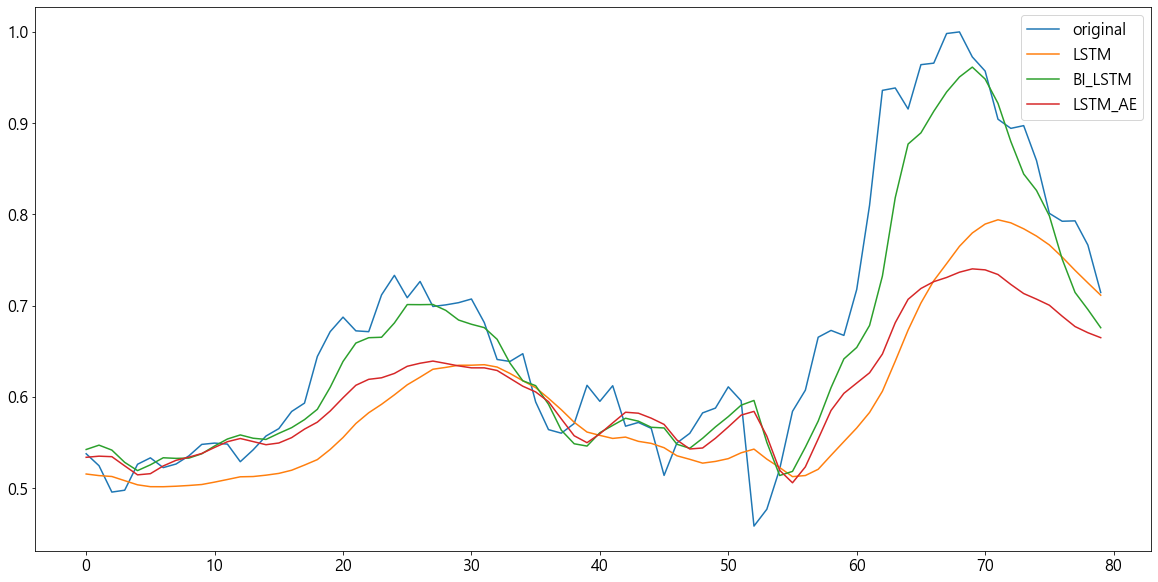

In [ ]:
plt.plot(y_test2, label = 'original')
plt.plot(pred1, label='LSTM')
plt.plot(pred2, label='BI_LSTM')
plt.plot(pred3, label='LSTM_AE')
plt.legend()
plt.show()

### 그래프를 그리기 위해 데이터프레임 병합

In [ ]:
final_df = forecast.iloc[-80:][['ds','trend']]
final_df = pd.concat([final_df,b['predicted_mean']],axis=1)
final_df.rename(columns={'trend' : 'Prophet', 'predicted_mean' : 'ARIMA',}, inplace=True)
final_df['LSTM'] = pred1
final_df['BI_LSTM'] = pred2
final_df['LSTM_AE'] = pred3
final_df['KOSPI'] = y_test2
for col in final_df.columns[3:]:
    final_df[col] = scaler3.inverse_transform(final_df[[col]])
final_df.head()

,ds,Prophet,ARIMA,LSTM,BI_LSTM,LSTM_AE,KOSPI
162,2015-10-01,2118.432653,2040.513821,1948.868896,2021.630005,1998.400391,2008.975238
163,2015-11-01,2123.592335,2045.144557,1944.145264,2034.512573,2001.811768,1973.438095
164,2015-12-01,2128.924006,2055.078468,1941.503662,2019.841064,2000.296875,1895.199000
165,2016-01-01,2134.255678,2061.822649,1929.085327,1983.415527,1973.015381,1900.810556
166,2016-02-01,2139.243370,2069.696231,1916.784302,1958.976318,1946.380371,1977.790455


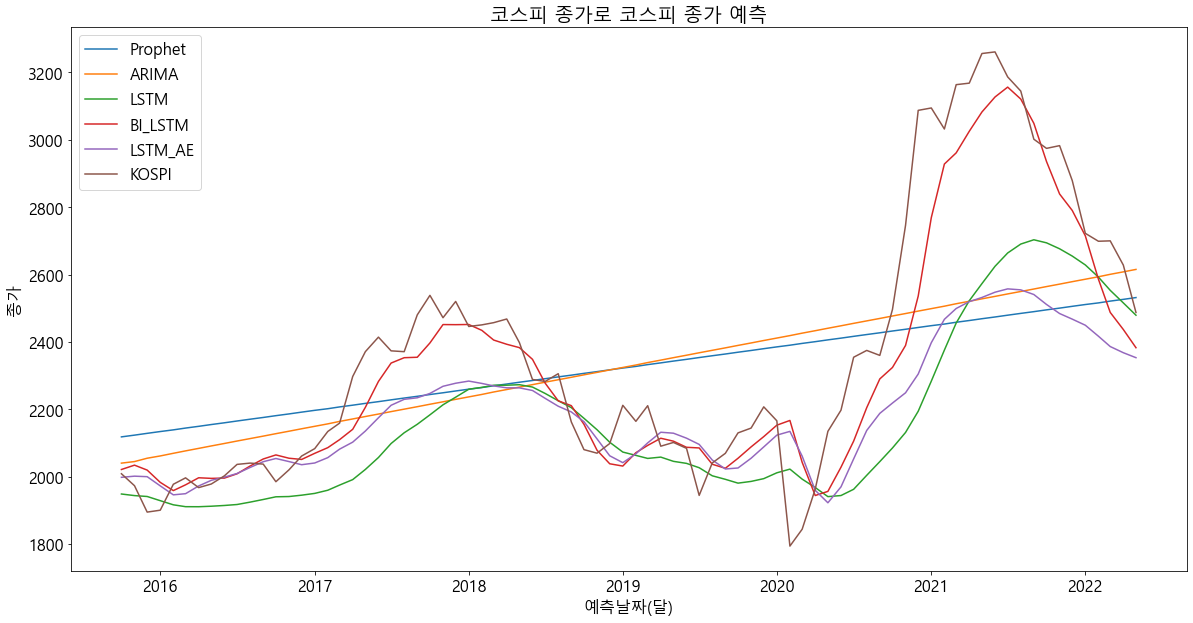

In [ ]:
# 전체 모델 예측값 시각화
plt.title('코스피 종가로 코스피 종가 예측')
for col in final_df.columns[1:]:
    sns.lineplot(data=final_df, x='ds', y=col, label=col)
plt.ylabel('종가')
plt.xlabel('예측날짜(달)')
plt.show()

---
### 선별한 필라델피아반도체, S&P500, WTI유가전처리, 금값, 나스닥, 물가지수, 상해종합, 주택매매가격지수 데이터를 통한 코스피 예측
---

---
### 딥러닝을 위한 전처리
---

In [ ]:
# 딥러닝 학습을 위해 입력과 결과로 나눈다
X = df2[col_list]
y = df2['코스피']

In [ ]:
# 딥러닝 학습을 위해 표준화한다.
scaler2 = StandardScaler()
X = scaler2.fit_transform(X)
scaler3 = MinMaxScaler()
y = scaler3.fit_transform(y.values.reshape(-1, 1))

In [ ]:
# 입력노드의 개수
input_size = X.shape[1]
input_size

8

In [ ]:
# 머신러닝과 동일하게 80개월을 에측하기위해 데이터를 분리한다.(20개월치로 다음달을 예측하기에 100개월치를 test데이터로 사용)
X_train = X[:-100]
X_test = X[-100:]
y_train = y[:-100]
y_test = y[-100:]

In [ ]:
# 결과를 확인하기 위한 앞선 데이터의 수
WINDOW_SIZE = 20
# 데이터 배치 사이즈
BATCH_SIZE = 32
# optimizer
optimizer = 'adam'

In [ ]:
# train_data는 학습용 데이터셋, test_data는 검증용 데이터 셋
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

### LSTM

In [ ]:
# 신경망 설계
model_LSTM = Sequential()
# CNN
model_LSTM.add(Conv1D(32, kernel_size=3,
                padding='causal',
                input_shape=[WINDOW_SIZE, 1]))
model_LSTM.add(Activation('relu'))

# LSTM
model_LSTM.add(LSTM(16))
model_LSTM.add(Activation('tanh'))
model_LSTM.add(Dropout(0.5))
# 선형
model_LSTM.add(Dense(16))
model_LSTM.add(Activation('relu'))


# 출력층
model_LSTM.add(Dense(out_nodes))

# 모델 컴파일
model_LSTM.compile(loss=loss, optimizer=optimizer)
model_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 20, 32)            128       
                                                                 
 activation_7 (Activation)   (None, 20, 32)            0         
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 activation_8 (Activation)   (None, 16)                0         
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 activation_9 (Activation)   (None, 16)               

### BI_LSTM

In [ ]:
# 신경망 설계
model_BI_LSTM = Sequential()
# CNN
model_BI_LSTM.add(Conv1D(32, kernel_size=3,
                padding='causal',
                input_shape=[WINDOW_SIZE, 1]))
model_BI_LSTM.add(Activation('relu'))

# 양방향 LSTM
model_BI_LSTM.add(Bidirectional(LSTM(16, return_sequences=True)))
model_BI_LSTM.add(Bidirectional(LSTM(16)))
model_BI_LSTM.add(Dropout(0.5))

# 출력층
model_BI_LSTM.add(Dense(out_nodes))

# 모델 컴파일
model_BI_LSTM.compile(loss=loss, optimizer=optimizer)
model_BI_LSTM.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 20, 32)            128       
                                                                 
 activation_10 (Activation)  (None, 20, 32)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 32)           6272      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

### LSTM_AE

In [ ]:
# 신경망 설계
model_LSTM_AE = Sequential()
# CNN
model_LSTM_AE.add(Conv1D(32, kernel_size=3,
           padding='causal',
           input_shape=[WINDOW_SIZE, 1]))
model_LSTM_AE.add(Activation('relu'))

model_LSTM_AE.add(LSTM(32))
model_LSTM_AE.add(Activation('relu'))
# model_LSTM_AE.add(Dropout(0.5))
model_LSTM_AE.add(RepeatVector(out_nodes))
model_LSTM_AE.add(LSTM(32, return_sequences=True))
model_LSTM_AE.add(Activation('relu'))
# model_LSTM_AE.add(Dropout(0.5))
model_LSTM_AE.add(TimeDistributed(Dense(1)))

model_LSTM_AE.compile(loss=loss, optimizer=optimizer)
model_LSTM_AE.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 20, 32)            128       
                                                                 
 activation_11 (Activation)  (None, 20, 32)            0         
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 activation_12 (Activation)  (None, 32)                0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 1, 32)            0         
 or)                                                             
                                                                 
 lstm_9 (LSTM)               (None, 1, 32)             8320      
                                                      

In [ ]:
model_dic = {'model_LSTM' : model_LSTM,
              'model_BI_LSTM' : model_BI_LSTM,
              'model_LSTM_AE' : model_LSTM_AE}
history_dic = {'history' : []}
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):    
    clear_output(wait=True)
for models in model_dic:
    path1 = path + f'/{models}2.h5'
    # 저장콜백
    callbacks = [ModelCheckpoint(filepath=path1, monitor='val_loss', save_best_only=True),
                 EarlyStopping(monitor='val_loss', patience=50), 
                 TensorBoard(log_dir=path +'./logs', histogram_freq=1),
                 DisplayCallback()
                ]
    history = model_dic[models].fit(train_data,
                       validation_data=(test_data),
                       epochs=10000,
                       callbacks=callbacks)
    history_dic['history'].append(history)
    print(f'{models} 학습완료')

4/4 [==============================] - 0s 52ms/step - loss: 8.9028e-04 - val_loss: 0.0059
model_LSTM_AE 학습완료


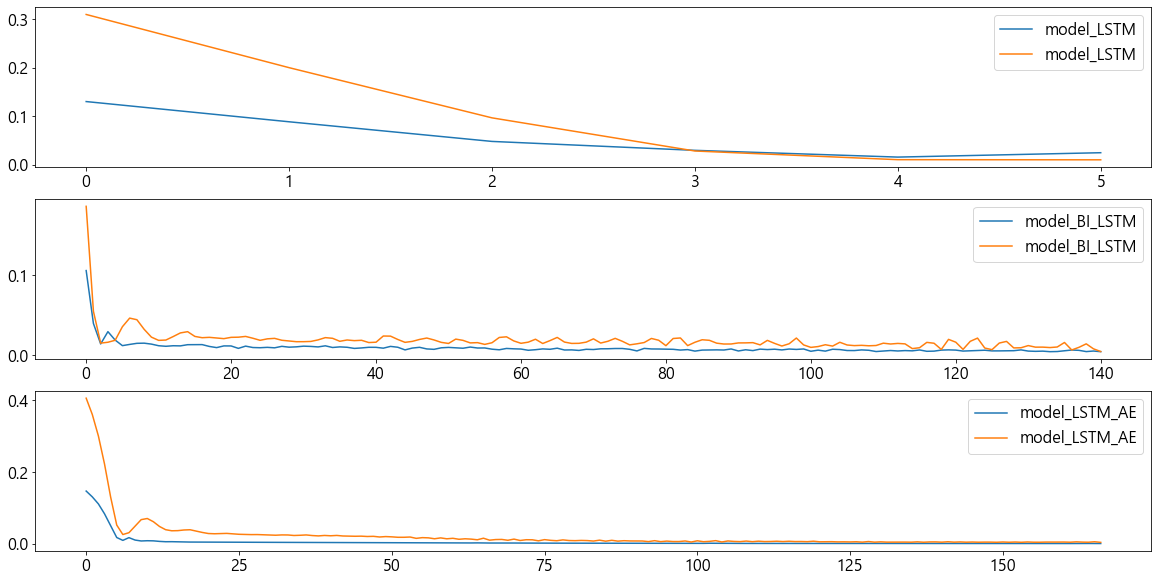

In [ ]:
# 손실률 그래프로 시각화
for idx, his in enumerate(history_dic['history']):
    # 리스트를 추출한다.
    loss_list = his.history['loss']
    val_loss_list = his.history['val_loss']
    # 손실률
    plt.subplot(311+idx)
    plt.plot(loss_list[:-50], label=list(model_dic.keys())[idx])
    plt.plot(val_loss_list[:-50], label=list(model_dic.keys())[idx])
    plt.legend()
plt.show()

In [ ]:
# 모델을 가져온다.
model_LSTM = load_model('./model/model_LSTM2.h5')
model_BI_LSTM = load_model('./model/model_BI_LSTM2.h5')
model_LSTM_AE = load_model('./model/model_LSTM_AE2.h5')

In [ ]:
# 검증데이터를 통해 예측 결과를 가져온다.
pred1 = model_LSTM.predict(test_data)
pred1 = pred1.reshape(-1)
pred2 = model_BI_LSTM.predict(test_data)
pred2 = pred2.reshape(-1)
pred3 = model_LSTM_AE.predict(test_data)
pred3 = pred3.reshape(-1)

3/3 [==============================] - 0s 13ms/step


In [ ]:
# 원래 결과를 1차원으로 변환한다.
y_test2 = y_test.reshape(-1)
# 20일치를 가지고 21일째를 예측하기 떄문에
# 앞선 20일은 예측하지 않는다.
y_test2 = y_test2[20:]

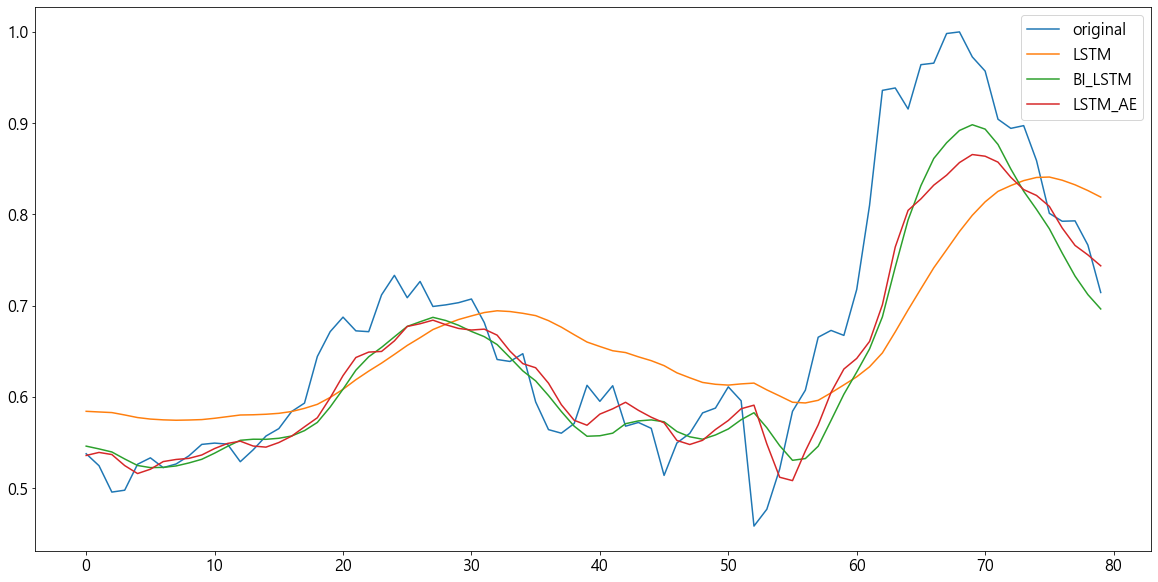

In [ ]:
# 양방향 LSTM
plt.plot(y_test2, label = 'original')
plt.plot(pred1, label='LSTM')
plt.plot(pred2, label='BI_LSTM')
plt.plot(pred3, label='LSTM_AE')
plt.legend()
plt.show()

### 그래프를 그리기 위해 데이터프레임 병합

In [ ]:
final_df = final_df[['ds', 'LSTM', 'BI_LSTM', 'LSTM_AE', 'KOSPI']]
final_df['LSTM'] = pred1
final_df['BI_LSTM'] = pred2
final_df['LSTM_AE'] = pred3
for col in final_df.columns[1:-1]:
    final_df[col] = scaler3.inverse_transform(final_df[[col]])
final_df.head()

,ds,LSTM,BI_LSTM,LSTM_AE,KOSPI
162,2015-10-01,2134.950928,2031.580444,2003.920044,2008.975238
163,2015-11-01,2133.016113,2023.365845,2012.932129,1973.438095
164,2015-12-01,2131.206055,2014.257690,2006.650024,1895.199000
165,2016-01-01,2124.105713,1993.476318,1973.874390,1900.810556
166,2016-02-01,2116.420654,1974.147217,1950.207764,1977.790455


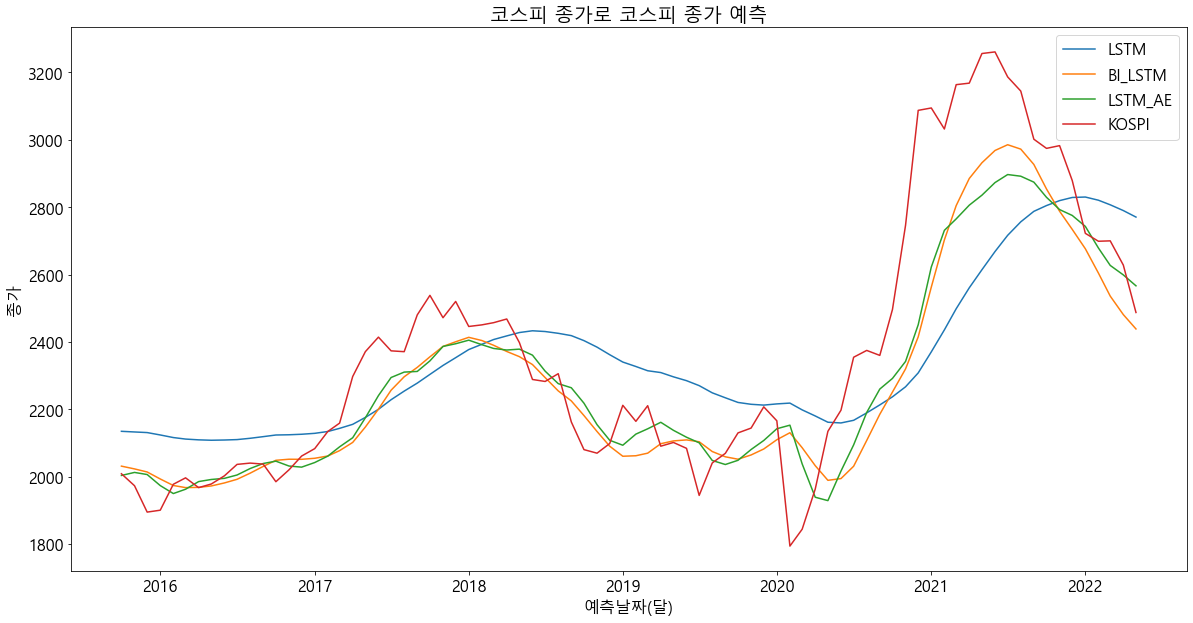

In [ ]:
# 전체 모델 예측값 시각화
plt.title('다양한 데이터로 코스피 종가 예측')
for col in final_df.columns[1:]:
    sns.lineplot(data=final_df, x='ds', y=col, label=col)
plt.ylabel('종가')
plt.xlabel('예측날짜(달)')
plt.show()

---
# 결론
1. 데이터의 중요성 : 월별/년도별 상관계수를 뽑기 위한 데이터 전처리 과정에서 상관계수 차이 발생
2. 그래프 추이 확인 : 초기에 세운 가설과 달리 상관계수에 따른 KOSPI 예측 차이가 크지 않음
3. AI의 한계 : 과거의 자료로 미래 예측은 무모한 시도이기에 KOSPI예측이 불가능하며 추이정도만 참고 가능하다. 다양한 잠재적 변수에 대한 고려가 필요하고, 모델 구성 및 설정 변화를 통해 정확도 개선이 가능하다.
---
